In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/praktikum_ml/praktikum04'

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)


In [10]:
df = pd.read_csv(path + '/data/stunting_wasting_dataset.csv')
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [12]:
## buat cek missing value
df.isnull().sum()

,0
Jenis Kelamin,0
Umur (bulan),0
Tinggi Badan (cm),0
Berat Badan (kg),0
Stunting,0
Wasting,0


In [22]:
df = df.drop_duplicates()

In [23]:
df.duplicated().sum()

np.int64(0)

In [15]:
df['Stunting'].unique()

array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [17]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

In [52]:
## buat mapping kolom stunting -> biner
map_stunt = {'Stunted': 1, 'Severely Stunted' : 1, 'Normal': 0, 'Tall': 0}
df['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

##buat mapping jenis kelamin -> biner
## laki laki = 1, perempuan = 0
df['JK_bin'] = df['Jenis Kelamin'].map({'Laki-laki': 1, 'Perempuan': 0}).astype('Int64')


print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())


Distribusi Stunting_bin:
 Stunting_bin
0    72320
1    20372
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    46353
0    46339
Name: count, dtype: Int64


In [53]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.874162,0.659566,0.037173,0.000636
Tinggi Badan (cm),0.874162,1.000000,0.618453,-0.288216,0.070159
Berat Badan (kg),0.659566,0.618453,1.000000,0.020676,0.043446
Stunting_bin,0.037173,-0.288216,0.020676,1.000000,-0.005187
JK_bin,0.000636,0.070159,0.043446,-0.005187,1.000000


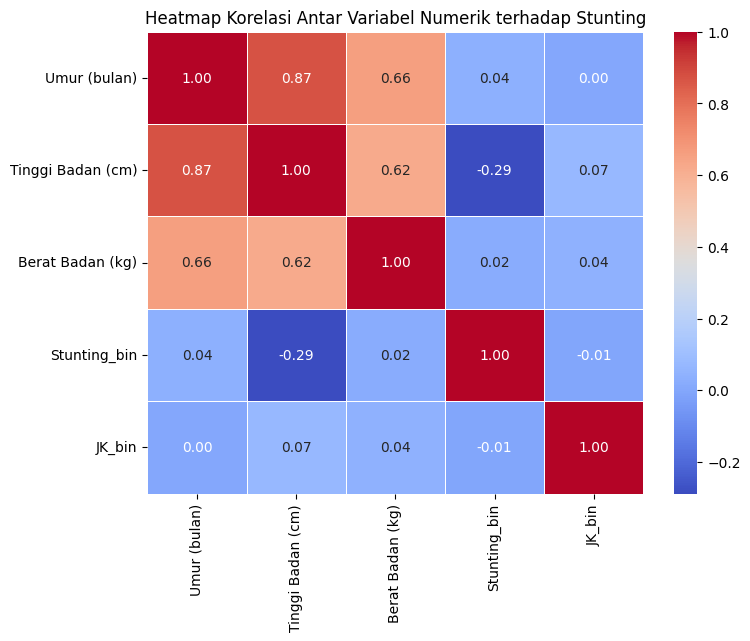

In [54]:
## buat visualisasi heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap Korelasi Antar Variabel Numerik terhadap Stunting", fontsize=12)
plt.show()

In [28]:
# fitur menarik dan gender

feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

##gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (92692, 4)
y shape: (92692,)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)



print("Data latih: ", X_train.shape)
print("Data uji: ", X_test.shape)

Data latih:  (74153, 4)
Data uji:  (18539, 4)


In [31]:
## scale hanya fitur numerik, gender langsung pass through

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ],
    remainder='drop'
)

model = LogisticRegression(
    max_iter = 1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', model)
])

## buat latih model
clf.fit(X_train, y_train)
print("Model Logistic regression berhasil dilatih")

Model Logistic regression berhasil dilatih


In [32]:
## prediksi dan probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

## hitung metrik
print(f"Akurasi : {accuracy_score(y_test, y_pred)}")
print(f"Precision : {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall : {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob):.4f}")


Akurasi : 0.8895841199633205
Precision : 0.6823
Recall : 0.9313
F1 Score : 0.7876
ROC-AUC  : 0.9598


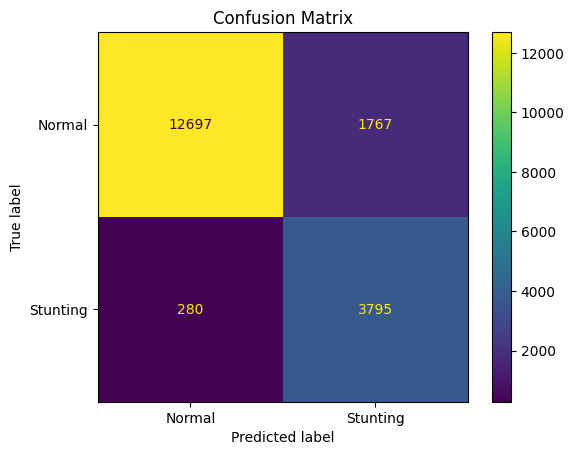

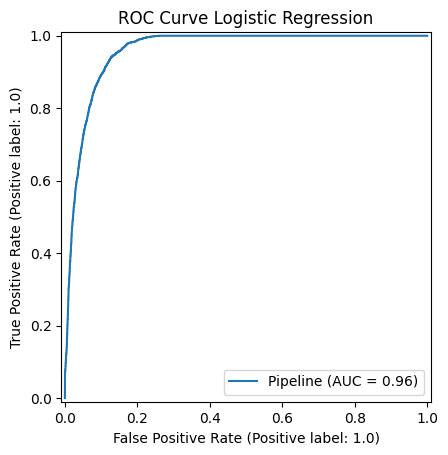

In [33]:
## confusion Matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['Normal', 'Stunting']).plot(values_format='d')

plt.title("Confusion Matrix")
plt.show()

## ROC curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logistic Regression")
plt.show()

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak stunting(0)', 'Stunting (1)']))


                   precision    recall  f1-score   support

Tidak stunting(0)       0.98      0.88      0.93     14464
     Stunting (1)       0.68      0.93      0.79      4075

         accuracy                           0.89     18539
        macro avg       0.83      0.90      0.86     18539
     weighted avg       0.91      0.89      0.90     18539



In [35]:
from sklearn.model_selection import cross_val_score

# lakukan cross validation (cv=5 berarti 5-fold)
scores = cross_val_score(clf, X, y, cv=5)

##tampilkan hasil
print("skor tiap fold:", scores)
print("Rata-Rata akurasi:", np.mean(scores))
print("Standar Deviasi:", np.std(scores))


skor tiap fold: [0.89077081 0.88532283 0.88537059 0.88801381 0.88224188]
Rata-Rata akurasi: 0.8863439843171814
Standar Deviasi: 0.002870629650854259


In [43]:
## ambil nama fitur dan koefisien
feat_names = feature_num + feature_bin
coefs = clf.named_steps['model'].coef_[0]
odds = np.exp(coefs)

coef_df = pd.DataFrame({
    'Fitur' : feat_names,
    'Koefisien (log-odds)' : coefs,
    'Odds Ratio (e^coef)' : odds
}).sort_values('Odds Ratio (e^coef)', ascending=False)


display(coef_df)

,Fitur,Koefisien (log-odds),Odds Ratio (e^coef)
0,Umur (bulan),7.361084,1573.542140
2,Berat Badan (kg),0.668201,1.950725
3,JK_bin,0.000000,1.000000
1,Tinggi Badan (cm),-9.187455,0.000102


In [48]:
## contoh 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24,10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

hasil = data_baru.copy()
hasil['Prob_Stunting'] = prob
hasil['Pred (0=Tidak,1=Ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_Stunting,"Pred (0=Tidak,1=Ya)"
0,24,79.0,9.2,1,0.991818,1.0
1,10,72.5,7.8,0,0.010382,0.0
